In [410]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Model
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from keras.regularizers import l2
import joblib

In [411]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append("/Users/Codes/Bitcoin_trader")

In [412]:
from positions import Positions
from order_class import BuyOrder, SellOrder

In [413]:
df = pd.read_csv('../data/btc_15m_data_2018_to_2025_with_indicators.csv')

df.dropna(inplace=True)

In [414]:
# y = df['predict_trend']
# x = df.drop(columns=['predict_trend'])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Signal'])

# Prepare data
X = df.drop(['Signal'], axis=1)
y = y_encoded




In [415]:
model = joblib.load('../models/xgboost_model.joblib')


In [416]:
X_test = X.drop(columns=['Open time'])
y_pred = model.predict(X_test)

In [417]:
y_pred[10000:10010]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [418]:
df.columns

Index(['Open time', 'Close', 'Volume', 'SMA_50', 'EMA_50', 'WMA_50',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'RSI_14',
       'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0',
       'ADX_14', 'DMP_14', 'DMN_14', 'STOCHk_14_3_3', 'STOCHd_14_3_3',
       'WILLR_14', 'ROC_10', 'CCI_20_0.015', 'ATRr_14', 'TSI_13_25_13',
       'TSIs_13_25_13', 'ISA_9', 'ISB_26', 'ITS_9', 'IKS_26', 'ICS_26', 'OBV',
       'VWAP_D', 'DCL_20_20', 'DCM_20_20', 'DCU_20_20', 'EMA_10', 'Signal'],
      dtype='object')

In [419]:
price = df['Close']
signals = y_pred

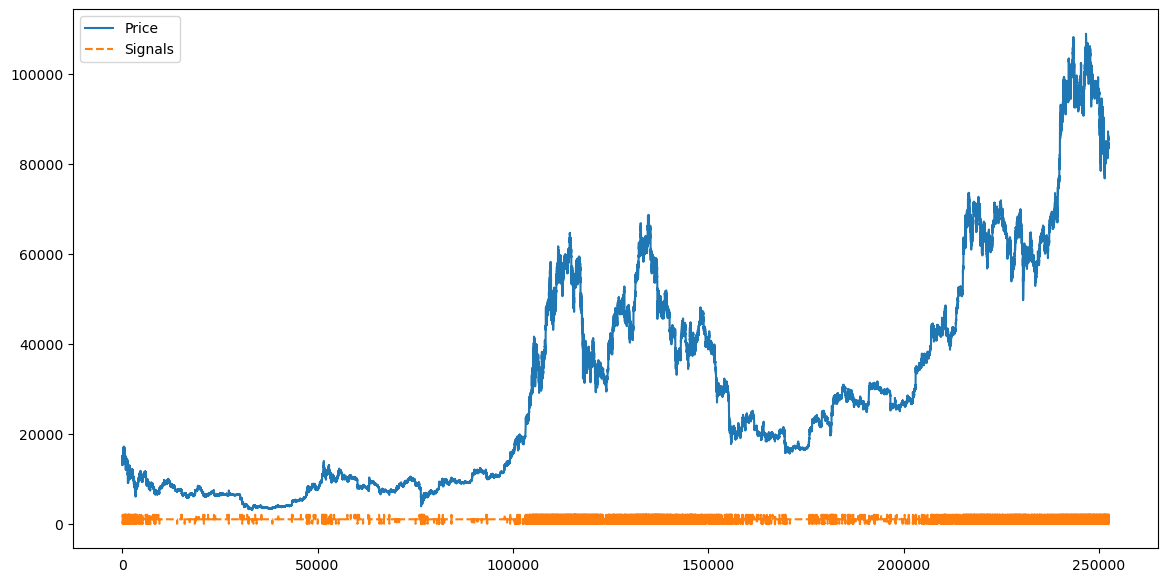

In [420]:
##plot price and signals
plt.figure(figsize=(14, 7))
plt.plot(price, label='Price')
plt.plot(signals * 1000, label='Signals', linestyle='dashed')
plt.legend()

plt.show()

In [421]:
stloss = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]
takeprofit = [tp*3 for tp in stloss]

In [422]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import List
from positions import Positions
from order_class import BuyOrder, SellOrder

def backtest(prices: List[float], signals: List[int], stop_loss: float, take_profit: float,
             initial_capital: float = 10000, quantity: int = 1, last_n: int = None) -> dict:
    """
    Backtest a trading strategy with visualizations and formatted results.
    """
    # ... [previous initialization code] ...

    # Initialize tracking for visualization
    capital_history = [initial_capital]
    closed_positions = []


    if last_n is not None:
        prices = prices[-last_n:].reset_index(drop=True)
        signals = signals[-last_n:]

    
    positions = Positions(initial_capital)
    
    for i, (price, signal) in enumerate(zip(prices, signals)):
        # Check and close existing positions
        positions.check_positions(price)
        
        # Open new position based on signal
        if signal == 0:  # Buy signal
            try:
                buy_order = BuyOrder(entry_price=price, quantity=quantity, stoploss=stop_loss, takeprofit=take_profit)
                positions.add_position(buy_order)
                print("Buy signal at", price )
            except ValueError:
                pass  # Insufficient capital, skip this trade
        elif signal == 2:  # Sell signal
            sell_order = SellOrder(entry_price=price, quantity=quantity, stoploss=stop_loss, takeprofit=take_profit)
            positions.add_position(sell_order)
            print("Sell signal at", price)
        # Track capital after each step
        capital_history.append(positions.get_current_capital())

    # ... [remaining position closing and result calculation code] ...
    positions.close_all_positions(prices.iloc[-1])

    total_trades = positions.get_profit_count() + positions.get_loss_count()
    win_rate = positions.get_success_rate()
    profit_loss = positions.get_profit_loss()
    final_capital = positions.get_current_capital()
    total_return = (final_capital - initial_capital) / initial_capital * 100
    # Create formatted results table
    results = {
        "Total Trades": total_trades,
        "Win Rate (%)": f"{win_rate:.2f}",
        "Profit/Loss": f"${profit_loss:.2f}",
        "Initial Capital": f"${initial_capital:,.2f}",
        "Final Capital": f"${final_capital:,.2f}",
        "Return (%)": f"{total_return:.2f}%"
    }
    
    # Print formatted table
    print("📈 Backtest Results\n")
    print(pd.DataFrame.from_dict(results, orient='index').to_markdown(tablefmt="grid"))
    
    # # Create visualizations
    plt.figure(figsize=(14, 10))
    
    # Price and Signals Plot
    price_array = prices.values if isinstance(prices, pd.Series) else np.array(prices)
    signal_array = np.array(signals)

    plt.subplot(3, 1, 1)
    plt.plot(price_array, label='Price', color='navy')

    # Use boolean indexing for cleaner signal plotting
    buy_signals = np.where(signal_array == 0)[0]
    sell_signals = np.where(signal_array == 2)[0]

    plt.scatter(buy_signals, 
                price_array[buy_signals], 
                marker='^', color='lime', s=100, label='Buy Signal')
    plt.scatter(sell_signals, 
                price_array[sell_signals], 
                marker='v', color='red', s=100, label='Sell Signal')

    plt.title('Price Action with Trading Signals')
    plt.legend()
    plt.grid(True)

    # Equity Curve Plot
    plt.subplot(3, 1, 2)
    plt.plot(capital_history, color='darkgreen', linewidth=2)
    plt.title('Capital Evolution')
    plt.xlabel('Time Periods')
    plt.ylabel('Account Value')
    plt.grid(True)

    # Win/Loss Distribution
    plt.subplot(3, 1, 3)
    if total_trades > 0:
        labels = ['Profitable Trades', 'Losing Trades']
        sizes = [positions.get_profit_count(), positions.get_loss_count()]
        colors = ['#66b3ff', '#ff9999']
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                startangle=90, explode=(0.1, 0), shadow=True)
        plt.title('Trade Performance Distribution')
    else:
        plt.text(0.5, 0.5, 'No Trades Executed', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

    return results


In [423]:
signals.shape, price.shape

((252513,), (252513,))

Buy signal at 97203.29
Buy signal at 97147.99
Buy signal at 97295.7
Buy signal at 97614.44
Buy signal at 97600.0
Buy signal at 98048.65
Buy signal at 97988.0
Sell signal at 98331.12
Buy signal at 98074.0
Buy signal at 98280.01
Sell signal at 98789.52
Sell signal at 98699.38
Sell signal at 98360.0
Buy signal at 97829.83
Sell signal at 98278.55
Sell signal at 98562.89
Buy signal at 97901.67
Buy signal at 98118.16
Buy signal at 98135.4
Buy signal at 97949.99
Buy signal at 97831.46
Buy signal at 97973.8
Buy signal at 97888.22
Buy signal at 98189.98
Buy signal at 98239.13
Sell signal at 98554.55
Sell signal at 98536.99
Sell signal at 98430.48
Buy signal at 98153.98
Buy signal at 97987.57
Buy signal at 98171.58
Buy signal at 98373.72
Buy signal at 97900.0
Buy signal at 98081.6
Buy signal at 98256.48
Buy signal at 98337.65
Buy signal at 98580.59
Buy signal at 98617.46
Buy signal at 98913.57
Buy signal at 98656.01
Buy signal at 98647.5
Buy signal at 98836.5
Buy signal at 98773.96
Buy signal at

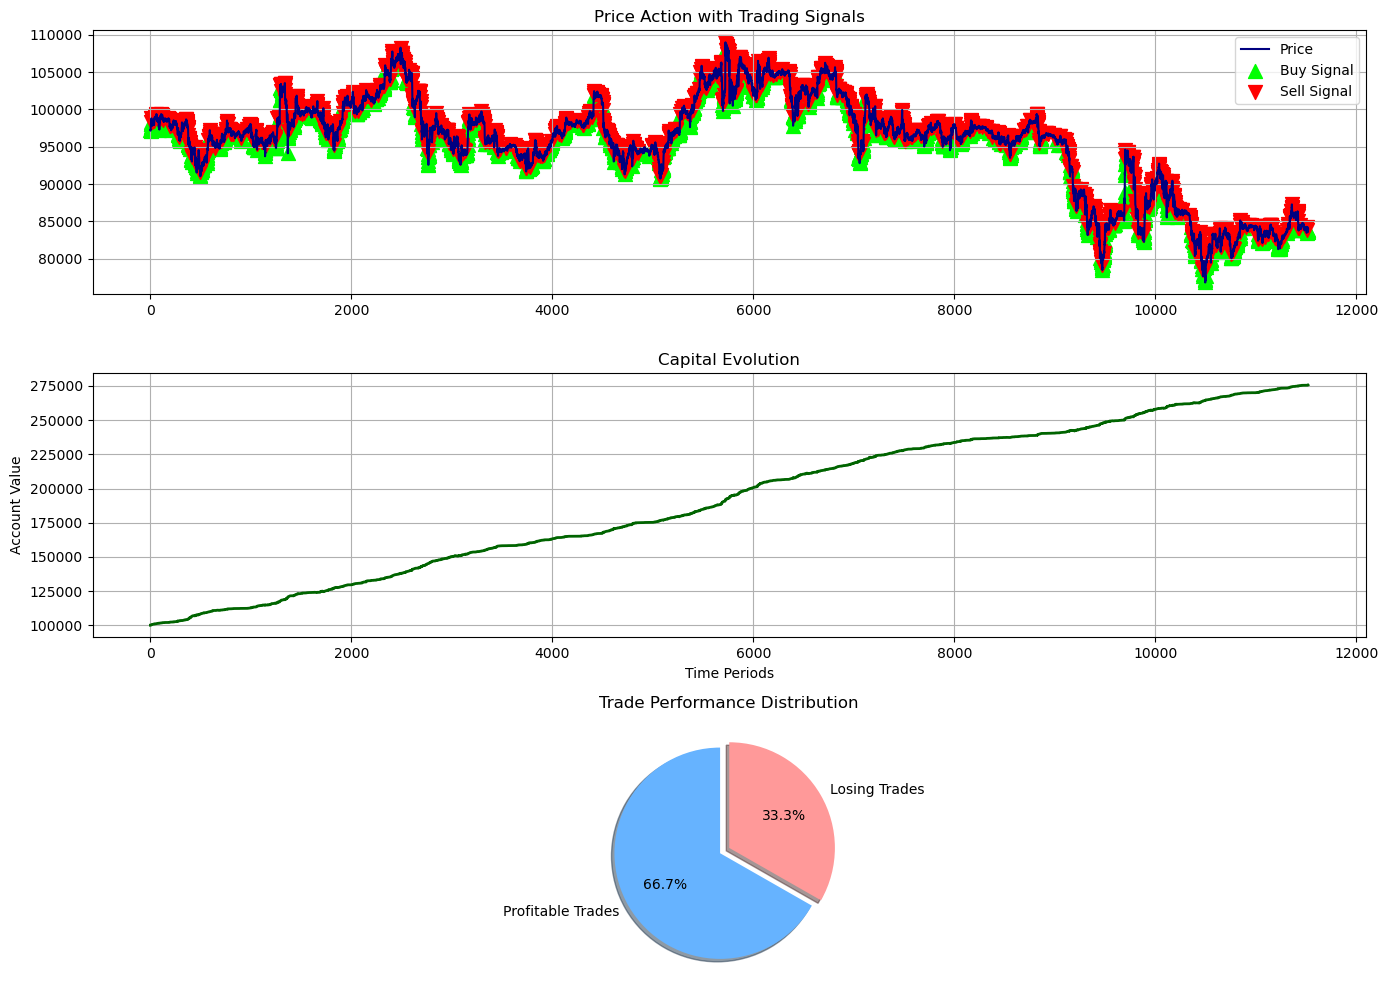

{'Total Trades': 7336,
 'Win Rate (%)': '0.67',
 'Profit/Loss': '$175654.99',
 'Initial Capital': '$100,000.00',
 'Final Capital': '$275,654.99',
 'Return (%)': '175.65%'}

In [424]:
backtest(price, signals, 0.001, 0.003, 100000, 0.1, 96*120)

Stop loss: 0.001
Take profit: 0.003
Sell signal at 66550.01
Sell signal at 66791.93
Sell signal at 66656.0
Sell signal at 66204.56
Sell signal at 66008.01
Buy signal at 65724.99
Buy signal at 65234.0
Buy signal at 65540.0
Buy signal at 64908.01
Buy signal at 65133.67
Buy signal at 65200.0
Buy signal at 65195.99
Buy signal at 65342.86
Buy signal at 65223.74
Buy signal at 65481.1
Buy signal at 65600.0
Buy signal at 65339.99
Buy signal at 65479.93
Buy signal at 65323.82
Buy signal at 65170.01
Buy signal at 65398.75
Buy signal at 65392.19
Buy signal at 65480.01
Buy signal at 65398.9
Buy signal at 65432.72
Buy signal at 65501.27
Buy signal at 65651.61
Buy signal at 65882.94
Buy signal at 65650.0
Buy signal at 65243.99
Buy signal at 65253.19
Buy signal at 65506.05
Buy signal at 65476.09
Sell signal at 65988.0
Sell signal at 65981.99
Sell signal at 65921.86
Sell signal at 65900.0
Sell signal at 66144.85
Sell signal at 66000.45
Sell signal at 66201.45
Sell signal at 66430.01
Sell signal at 665

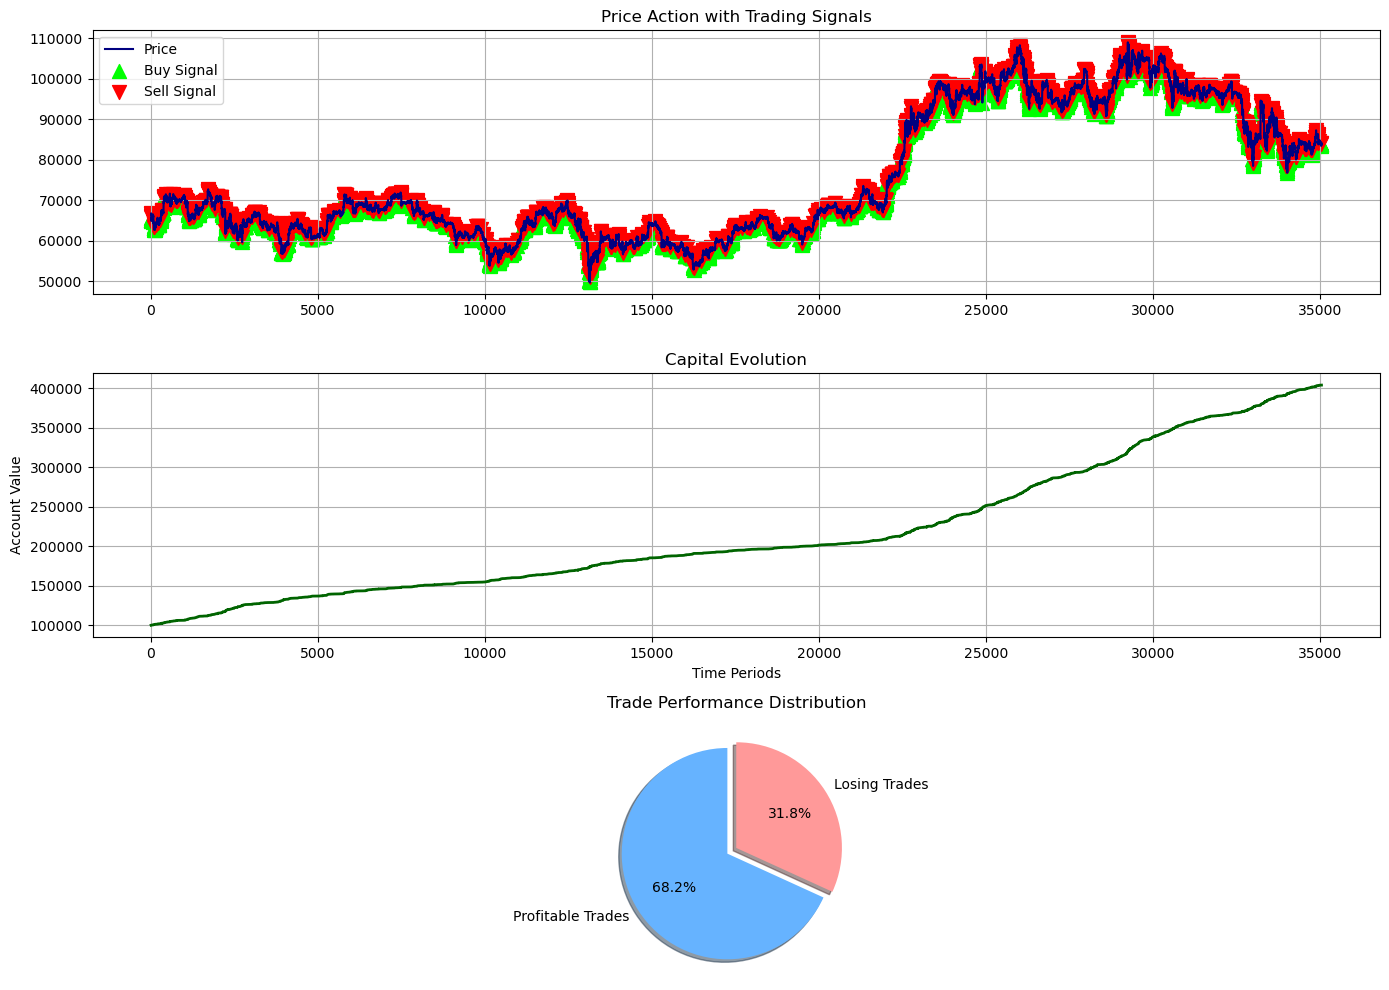



Stop loss: 0.002
Take profit: 0.006
Sell signal at 66550.01
Sell signal at 66791.93
Sell signal at 66656.0
Sell signal at 66204.56
Sell signal at 66008.01
Buy signal at 65724.99
Buy signal at 65234.0
Buy signal at 65540.0
Buy signal at 64908.01
Buy signal at 65133.67
Buy signal at 65200.0
Buy signal at 65195.99
Buy signal at 65342.86
Buy signal at 65223.74
Buy signal at 65481.1
Buy signal at 65600.0
Buy signal at 65339.99
Buy signal at 65479.93
Buy signal at 65323.82
Buy signal at 65170.01
Buy signal at 65398.75
Buy signal at 65392.19
Buy signal at 65480.01
Buy signal at 65398.9
Buy signal at 65432.72
Buy signal at 65501.27
Buy signal at 65651.61
Buy signal at 65882.94
Buy signal at 65650.0
Buy signal at 65243.99
Buy signal at 65253.19
Buy signal at 65506.05
Buy signal at 65476.09
Sell signal at 65988.0
Sell signal at 65981.99
Sell signal at 65921.86
Sell signal at 65900.0
Sell signal at 66144.85
Sell signal at 66000.45
Sell signal at 66201.45
Sell signal at 66430.01
Sell signal at 6

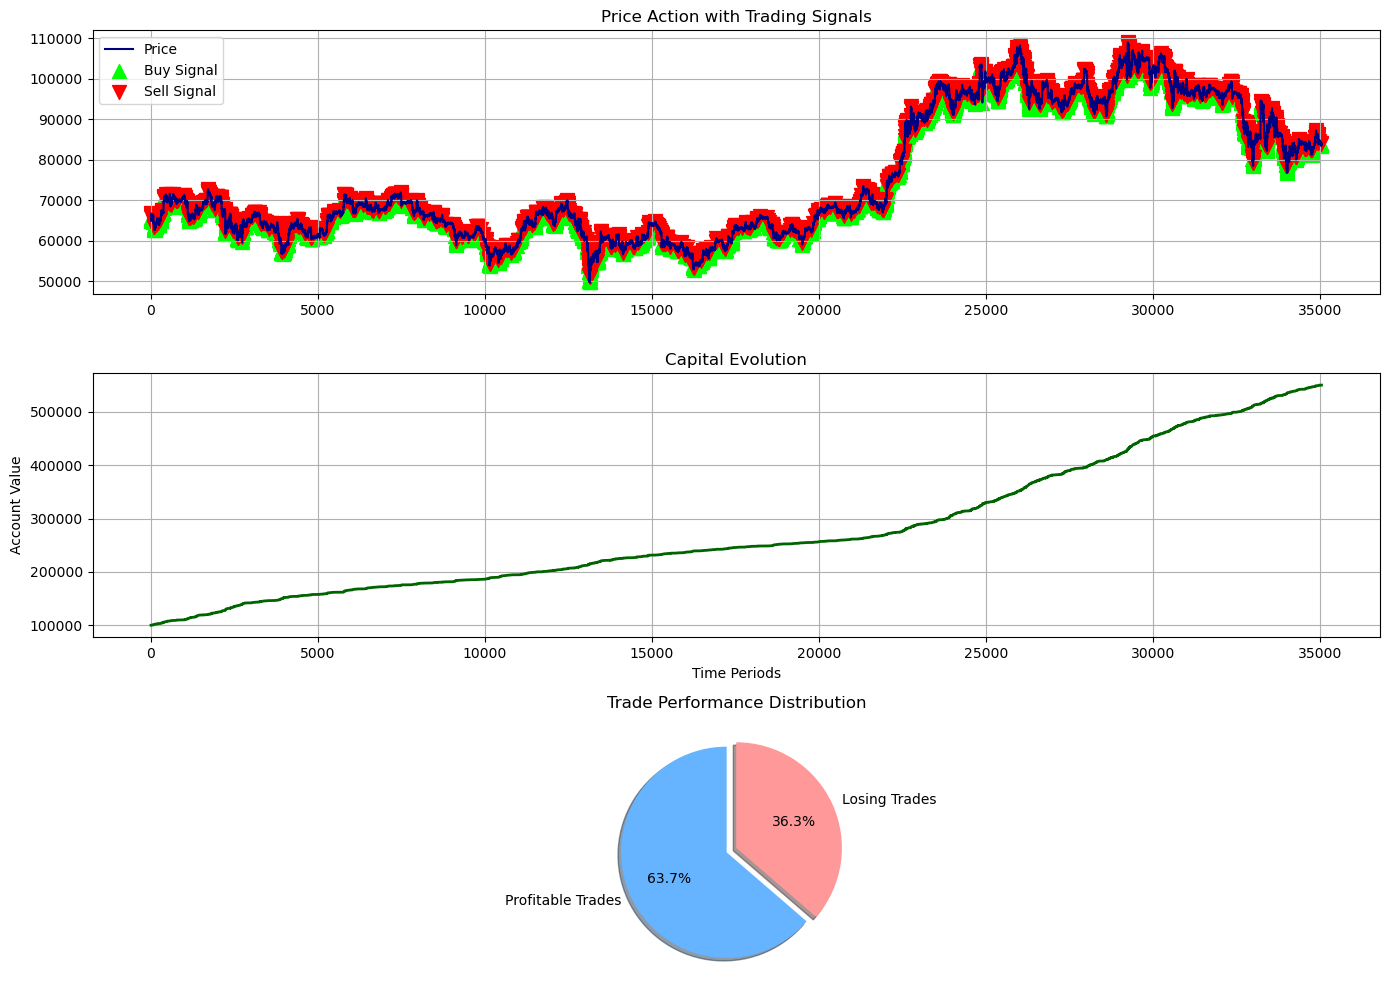



Stop loss: 0.003
Take profit: 0.009000000000000001
Sell signal at 66550.01
Sell signal at 66791.93
Sell signal at 66656.0
Sell signal at 66204.56
Sell signal at 66008.01
Buy signal at 65724.99
Buy signal at 65234.0
Buy signal at 65540.0
Buy signal at 64908.01
Buy signal at 65133.67
Buy signal at 65200.0
Buy signal at 65195.99
Buy signal at 65342.86
Buy signal at 65223.74
Buy signal at 65481.1
Buy signal at 65600.0
Buy signal at 65339.99
Buy signal at 65479.93
Buy signal at 65323.82
Buy signal at 65170.01
Buy signal at 65398.75
Buy signal at 65392.19
Buy signal at 65480.01
Buy signal at 65398.9
Buy signal at 65432.72
Buy signal at 65501.27
Buy signal at 65651.61
Buy signal at 65882.94
Buy signal at 65650.0
Buy signal at 65243.99
Buy signal at 65253.19
Buy signal at 65506.05
Buy signal at 65476.09
Sell signal at 65988.0
Sell signal at 65981.99
Sell signal at 65921.86
Sell signal at 65900.0
Sell signal at 66144.85
Sell signal at 66000.45
Sell signal at 66201.45
Sell signal at 66430.01
S

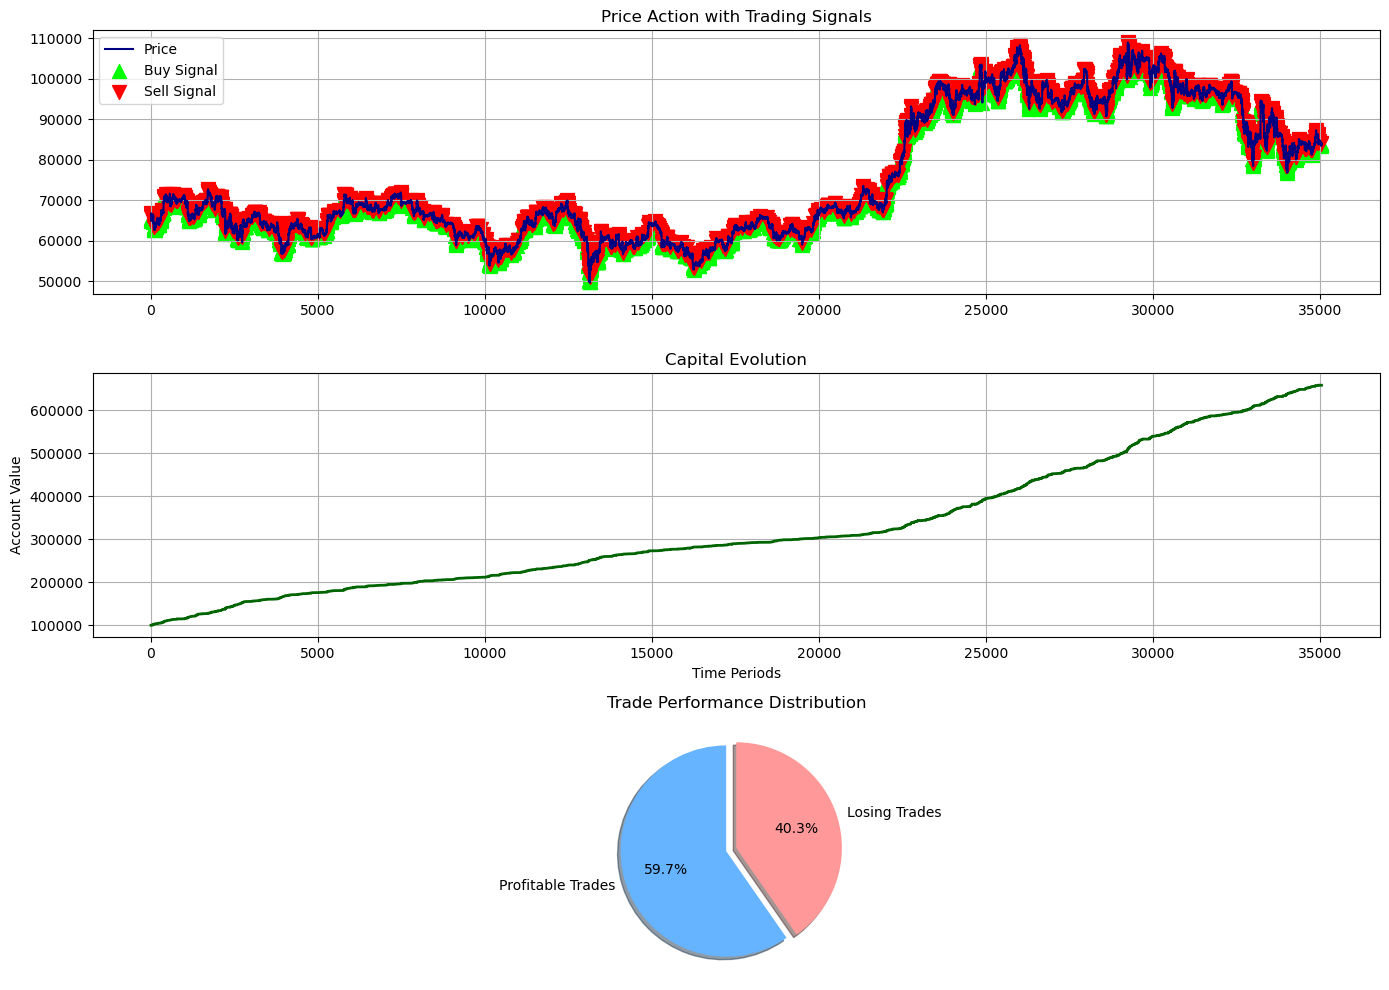



Stop loss: 0.004
Take profit: 0.012
Sell signal at 66550.01
Sell signal at 66791.93
Sell signal at 66656.0
Sell signal at 66204.56
Sell signal at 66008.01
Buy signal at 65724.99
Buy signal at 65234.0
Buy signal at 65540.0
Buy signal at 64908.01
Buy signal at 65133.67
Buy signal at 65200.0
Buy signal at 65195.99
Buy signal at 65342.86
Buy signal at 65223.74
Buy signal at 65481.1
Buy signal at 65600.0
Buy signal at 65339.99
Buy signal at 65479.93
Buy signal at 65323.82
Buy signal at 65170.01
Buy signal at 65398.75
Buy signal at 65392.19
Buy signal at 65480.01
Buy signal at 65398.9
Buy signal at 65432.72
Buy signal at 65501.27
Buy signal at 65651.61
Buy signal at 65243.99
Sell signal at 65988.0
Sell signal at 65981.99
Sell signal at 65921.86
Sell signal at 65900.0
Sell signal at 66144.85
Sell signal at 66000.45
Sell signal at 66201.45
Sell signal at 66430.01
Sell signal at 66543.01
Sell signal at 66448.08
Sell signal at 66178.01
Sell signal at 66287.92
Sell signal at 66264.41
Sell signa

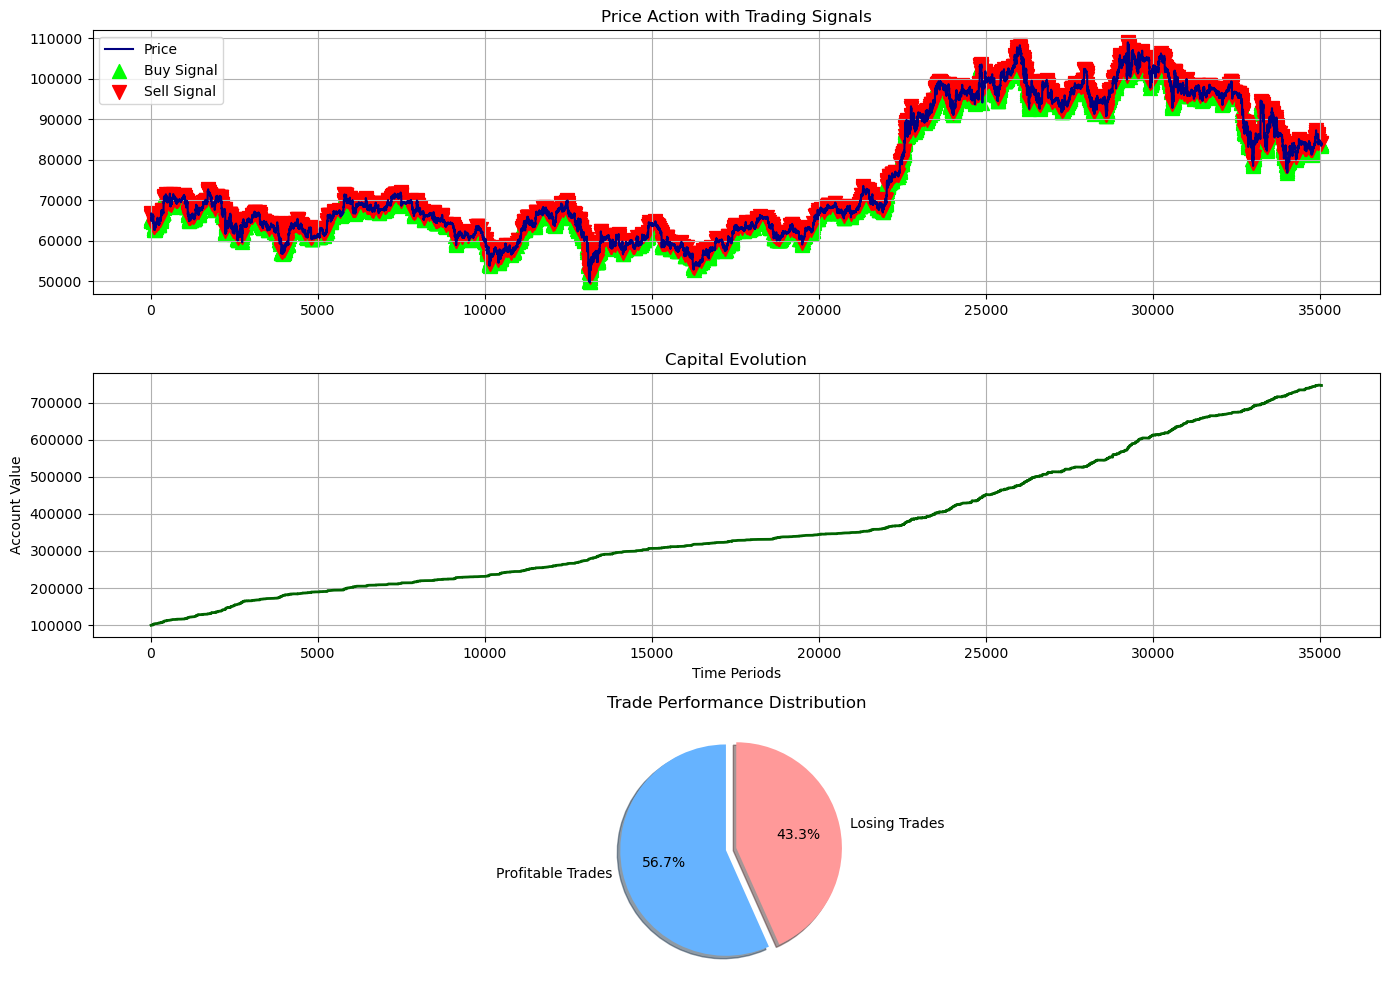



Stop loss: 0.005
Take profit: 0.015
Sell signal at 66550.01
Sell signal at 66791.93
Sell signal at 66656.0
Sell signal at 66204.56
Sell signal at 66008.01
Buy signal at 65724.99
Buy signal at 65234.0
Buy signal at 65540.0
Buy signal at 64908.01
Buy signal at 65133.67
Buy signal at 65200.0
Buy signal at 65195.99
Buy signal at 65342.86
Buy signal at 65223.74
Buy signal at 65481.1
Buy signal at 65600.0
Buy signal at 65339.99
Buy signal at 65479.93
Buy signal at 65323.82
Buy signal at 65170.01
Buy signal at 65398.75
Buy signal at 65392.19
Buy signal at 65480.01
Buy signal at 65882.94
Buy signal at 65243.99


ValueError: Insufficient capital to open buy position

In [425]:
for i in range(len(stloss)):
    st = stloss[i]
    tp = takeprofit[i]
    print(f"Stop loss: {st}")
    print(f"Take profit: {tp}")
    result = backtest(prices=price, signals=signals, stop_loss=st, take_profit=tp, initial_capital=100000, quantity=0.1, last_n=96*365)
    print("\n")